In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf
from datetime import datetime, timedelta

In [2]:
#função para tratar campo data
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

#Agora vamos importar nosso arquivo 
df = pd.read_excel('biometria.xlsx', sheet_name='Página1')
print(df.tail(10))

     Index    peso  comprimento_Total  comprimento_Padrao  comprimento_Cabeca  \
468  469.0  236.19               21.0                17.8                 6.1   
469  470.0  249.27               21.8                18.3                 5.6   
470  471.0  273.14               22.7                18.6                 5.6   
471  472.0  243.25               22.1                18.8                 6.7   
472  473.0  217.25               21.4                18.3                 5.4   
473  474.0  248.22               22.3                18.6                 6.0   
474  475.0  220.84               21.4                18.1                 6.0   
475  476.0  238.77               22.5                18.4                 6.4   
476  477.0  248.32               21.9                18.5                 5.8   
477  478.0  256.82               22.0                18.6                 6.0   

     altura  espessura       data  
468     7.4        3.1 2024-05-02  
469     7.6        3.1 2024-05-02  


In [4]:
df1 = df.drop(columns=[
'data', 
'Index'
])
df1.head()

,peso,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,espessura
0,51.45,14.3,12.2,4.0,4.1,1.9
1,37.15,12.4,10.9,3.8,3.2,1.2
2,47.26,13.7,11.2,3.4,4.0,1.7
3,36.67,12.9,11.1,3.7,3.7,1.6
4,45.48,13.2,11.3,3.8,4.5,1.6


## Creating the unseen_Data of 10% of the real data to check model results

In [9]:
data = df1.sample(frac=0.95, random_state=123)
data_unseen = df1.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (454, 6)
Unseen Data For Predictions: (24, 6)


In [10]:
for col in data.select_dtypes(include='number').columns:
    print(col)

peso
comprimento_Total
comprimento_Padrao
comprimento_Cabeca
altura
espessura


In [11]:
# Run this cel to make sure all the variable are type float64!
#data.info()

In [12]:
#from pycaret.datasets import get_data
#boston = get_data('boston')
from pycaret.regression import *
exp1 = setup(data = data,  target = 'peso', session_id=124, train_size=0.8, preprocess=False)


,Description,Value
0,Session id,124
1,Target,peso
2,Target type,Regression
3,Original data shape,"(454, 6)"
4,Transformed data shape,"(454, 6)"
5,Transformed train set shape,"(363, 6)"
6,Transformed test set shape,"(91, 6)"
7,Numeric features,5


In [18]:
best_model = compare_models(n_select=5 )  #default R2 sort='R2' TO select the metric R2

In [19]:
best_model

[RandomForestRegressor(n_jobs=-1, random_state=124),
 ExtraTreesRegressor(n_jobs=-1, random_state=124),
 LGBMRegressor(n_jobs=-1, random_state=124),
 AdaBoostRegressor(random_state=124),
 GradientBoostingRegressor(random_state=124)]

## Create Model
#### This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function. All the available models can be accessed using the models function.

In [20]:
rf = exp1.create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:25:56
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7141,48.8366,6.9883,0.9917,0.0476,0.0401
1,6.0541,86.3846,9.2943,0.9843,0.0580,0.0457
2,7.2716,120.0062,10.9547,0.9781,0.0682,0.0531
3,7.9549,186.6968,13.6637,0.9743,0.0661,0.0465
4,4.7031,41.6836,6.4563,0.9909,0.0597,0.0477
5,6.9701,118.8006,10.8996,0.9791,0.0639,0.0511
6,6.3011,79.4235,8.9120,0.9843,0.0751,0.0582
7,6.9448,103.5357,10.1752,0.9836,0.0614,0.0548
8,6.9747,89.5843,9.4649,0.9817,0.0654,0.0583


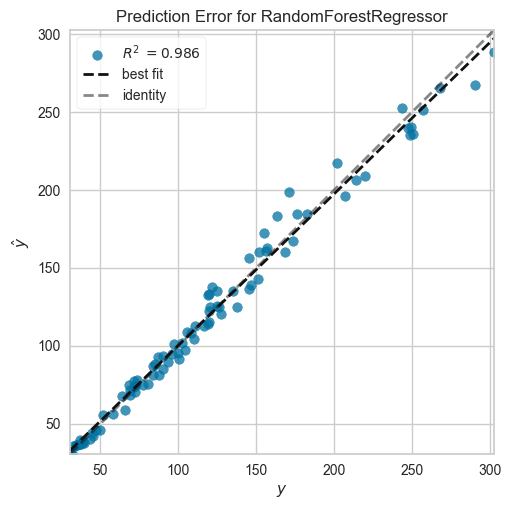

In [21]:
#plot_model(et, plot = 'residuals')
plot_model(rf, plot = 'error')
#plot_model(et, plot = 'feature')

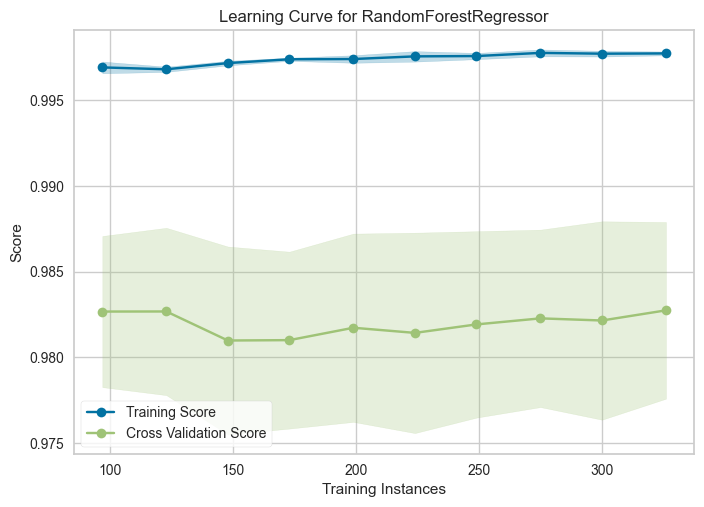

In [22]:
plot_model(rf, plot = 'learning')

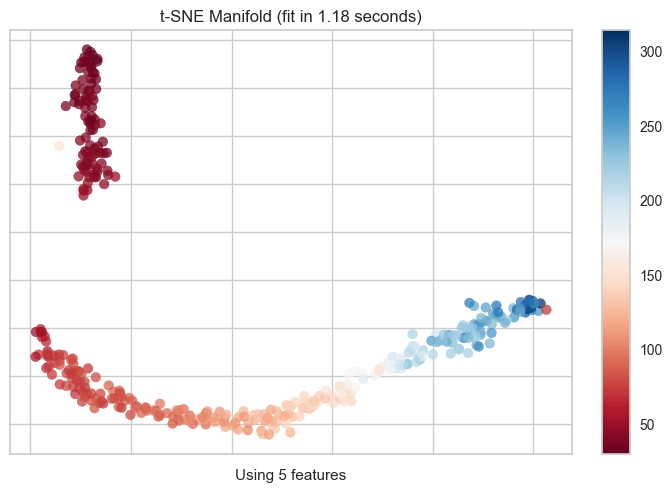

In [23]:
exp1.plot_model(rf, plot = 'manifold')

## Blend an d sTacking if it is necessary!

In [24]:
holdout_pred = exp1.predict_model(rf)
#holdout_pred.tail(5) # for the last  5 lines 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.8473,62.5293,7.9075,0.9862,0.0572,0.0494


In [25]:
unseen_predictions = exp1.predict_model(rf, data=data_unseen)
unseen_predictions.head(5) # first five lines

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.1912,80.9981,8.9999,0.9822,0.0600,0.0499


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,espessura,peso,prediction_label
0,12.7,10.8,3.3,3.7,1.6,37.130001,37.727100
1,13.0,11.0,3.3,4.2,1.8,46.599998,43.038401
2,12.2,10.3,3.1,3.6,1.6,33.959999,32.723100
3,13.4,11.2,3.3,4.0,1.8,43.389999,44.424900
4,12.7,10.9,3.2,3.6,1.6,36.990002,39.155700


## Tune model
#### This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.

In [28]:
tune_rf= exp1.tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.4030,47.9526,6.9248,0.9919,0.0473,0.0383
1,5.6951,71.8295,8.4752,0.9870,0.0569,0.0454
2,7.2476,120.8787,10.9945,0.9780,0.0676,0.0515
3,7.9574,169.6305,13.0242,0.9767,0.0661,0.0484
4,4.6793,40.8606,6.3922,0.9911,0.0621,0.0484
5,6.1830,92.7286,9.6296,0.9837,0.0585,0.0474
6,6.7040,91.7068,9.5764,0.9819,0.0793,0.0598
7,6.2941,88.2909,9.3963,0.9860,0.0600,0.0515
8,6.7600,89.8118,9.4769,0.9817,0.0625,0.0558


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [29]:
pred_unseen = predict_model(tune_rf, data = data_unseen)
pred_unseen.head(5) # first five lines


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.9110,79.9002,8.9387,0.9825,0.0560,0.0467


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,espessura,peso,prediction_label
0,12.7,10.8,3.3,3.7,1.6,37.130001,37.980262
1,13.0,11.0,3.3,4.2,1.8,46.599998,42.035793
2,12.2,10.3,3.1,3.6,1.6,33.959999,32.795634
3,13.4,11.2,3.3,4.0,1.8,43.389999,44.286533
4,12.7,10.9,3.2,3.6,1.6,36.990002,38.455375


In [27]:
# dashboard of pycaret
#evaluate_model(rf)

# EXPERIMENT 2 
### Weight predicition using database from esalq esperiment without espessura feature.

#################################################### EXPERIMENT 2 #################################################33

In [3]:
df2 = df.drop(columns=[
'data', 
'Index',
'espessura'
])
df2.head()

,peso,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura
0,51.45,14.3,12.2,4.0,4.1
1,37.15,12.4,10.9,3.8,3.2
2,47.26,13.7,11.2,3.4,4.0
3,36.67,12.9,11.1,3.7,3.7
4,45.48,13.2,11.3,3.8,4.5


In [31]:
data = df2.sample(frac=0.95, random_state=123)
data_unseen = df2.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (454, 5)
Unseen Data For Predictions: (24, 5)


In [4]:
from pycaret.regression import *
#exp2= setup(data = data,  target = 'peso')
#### Without unseen data
exp2= setup(data = df2,  target = 'peso')
best_model = exp2.compare_models()

,Description,Value
0,Session id,8604
1,Target,peso
2,Target type,Regression
3,Original data shape,"(478, 5)"
4,Transformed data shape,"(478, 5)"
5,Transformed train set shape,"(334, 5)"
6,Transformed test set shape,"(144, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,6.6586,110.6314,10.2407,0.9807,0.0650,0.0521,0.0510
et,Extra Trees Regressor,6.5956,113.1232,10.3024,0.9799,0.0660,0.0520,0.0370
ada,AdaBoost Regressor,7.6194,114.4180,10.5239,0.9798,0.0923,0.0753,0.0310
gbr,Gradient Boosting Regressor,6.9050,118.7228,10.6389,0.9791,0.0672,0.0535,0.0260
lightgbm,Light Gradient Boosting Machine,7.1734,124.6798,10.8257,0.9783,0.0665,0.0542,0.0610
xgboost,Extreme Gradient Boosting,7.7350,149.3598,11.9721,0.9739,0.0736,0.0593,0.0830
dt,Decision Tree Regressor,8.8034,179.9014,13.1674,0.9684,0.0834,0.0680,0.0070
ridge,Ridge Regression,11.0614,193.5480,13.7868,0.9656,0.2841,0.1343,0.0070
br,Bayesian Ridge,11.0320,193.4824,13.7849,0.9656,0.2840,0.1339,0.0090
lr,Linear Regression,11.0052,193.4377,13.7837,0.9656,0.2839,0.1335,0.4820


In [5]:
rf = exp2.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.7557,137.2795,11.7166,0.9736,0.0838,0.0677
1,7.1798,120.3889,10.9722,0.9763,0.0721,0.0603
2,4.8387,59.6691,7.7246,0.9876,0.0571,0.0470
3,9.5381,201.6227,14.1994,0.9697,0.0763,0.0589
4,4.6200,41.0758,6.4090,0.9924,0.0558,0.0470
5,7.6409,131.8246,11.4815,0.9754,0.0686,0.0550
6,7.4252,167.2615,12.9330,0.9749,0.0601,0.0454
7,6.6803,113.6823,10.6622,0.9834,0.0637,0.0498
8,6.0080,75.0839,8.6651,0.9841,0.0621,0.0520


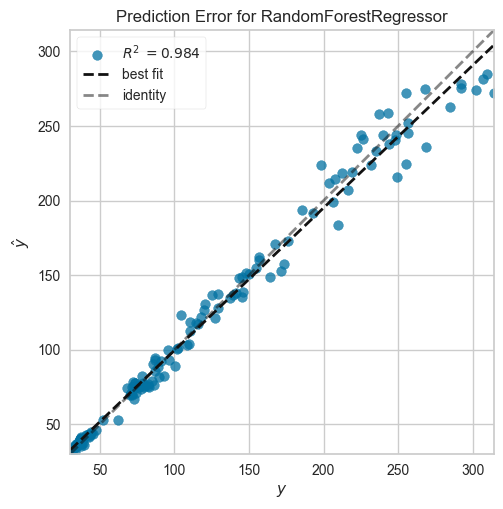

In [ ]:
exp2.plot_model(rf, plot = 'error')

In [6]:
exp2.evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [7]:
peso_pred_semEspe = exp2.predict_model(rf)
peso_pred_semEspe.head(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.7390,75.1253,8.6675,0.9844,0.0585,0.0469


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,peso,prediction_label
310,18.600000,16.200001,5.1,5.5,141.240005,134.673602
183,15.700000,13.500000,4.0,4.6,76.629997,75.622801
390,20.799999,18.000000,6.0,6.8,216.149994,206.631199
81,11.900000,10.000000,3.1,3.9,37.779999,33.515799
260,19.200001,16.299999,4.8,5.4,148.199997,141.540898


In [9]:
## Saving model 
# saving model 

save_model(rf, 'rf_weight') 


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['comprimento_Total',
                                              'comprimento_Padrao',
                                              'comprimento_Cabeca', 'altura'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  RandomForestRegressor(n_jobs=-1, random_state=8604))]),
 'rf_weight.pkl')

In [10]:
saved_rf = load_model('rf_weight') 

saved_rf 

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\crist\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['comprimento_Total',
                                             'comprimento_Padrao',
                                             'comprimento_Cabeca', 'altura'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model',
                 RandomForestRegressor(n_jobs=-1, random_state=8604))])

In [11]:
exp2.predict_model(saved_rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.7390,75.1253,8.6675,0.9844,0.0585,0.0469


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,peso,prediction_label
310,18.600000,16.200001,5.1,5.5,141.240005,134.673602
183,15.700000,13.500000,4.0,4.6,76.629997,75.622801
390,20.799999,18.000000,6.0,6.8,216.149994,206.631199
81,11.900000,10.000000,3.1,3.9,37.779999,33.515799
260,19.200001,16.299999,4.8,5.4,148.199997,141.540898
...,...,...,...,...,...,...
344,17.799999,15.300000,5.0,5.2,112.050003,121.647966
149,14.400000,12.700000,4.0,4.6,65.550003,63.919449
112,13.200000,11.000000,3.2,3.9,39.990002,40.667999
351,18.799999,16.100000,5.1,5.4,144.789993,136.345800


In [22]:
#pred_unseen = predict_model(rf, data = data_unseen)
#pred_unseen.head(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,3.0417,20.6230,4.5413,0.9840,0.0555,0.0411


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,peso,prediction_label
0,13.7,11.2,3.4,4.0,47.259998,43.527500
1,12.7,10.8,3.3,3.7,37.130001,37.228599
2,13.0,11.0,3.3,4.2,46.599998,42.633700
3,11.8,9.9,3.2,3.5,30.740000,32.120600
4,12.2,10.3,3.1,3.6,33.959999,32.908400


In [ ]:
#tuned_gbr = tune_model(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7974,39.0236,6.2469,0.9739,0.0576,0.0456
1,2.7883,14.7765,3.8440,0.9887,0.0520,0.0410
2,4.8336,41.1100,6.4117,0.9716,0.0620,0.0544
3,4.7503,38.9787,6.2433,0.9801,0.0600,0.0524
4,3.8073,27.0587,5.2018,0.9761,0.0642,0.0496
5,2.9277,16.8013,4.0989,0.9880,0.0495,0.0388
6,2.9499,18.5206,4.3036,0.9848,0.0476,0.0374
7,4.5485,36.9543,6.0790,0.9670,0.0627,0.0507
8,4.6366,43.4864,6.5944,0.9575,0.0646,0.0521


Fitting 10 folds for each of 10 candidates, totalling 100 fits


#### weight prediction 
#### Realizar um codigo padrao com avaliacao de modelos, tuning, evaluation, shuffle and save (retirar index)
#### realizar predicao para espessura
#### realizar a predicao do peso sem a variavel espessura

## TRy with biometria 4 
## importance study for each variable